# CSTAT Lab #2

This is the second lab of the computational statistics course, covering the confidence interval for mean, variance and their differences.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

In [2]:
df = pd.read_pickle("tpg_data.zip")
df.head()

,Date,Ligne,Ligne Type,Jour Semaine,Horaire Type,Arrêt,Arrêt Code Long,Indice Semaine,Indice Jour Semaine,Nombre de Montées,Nombre de Descentes,Mois Annee
0,2024-12-03,1,PRINCIPAL,2-Mardi,NORMAL,Belle-Idée-Centre,BLID00,49,2,118.05,5.06,2024-12
1,2024-12-03,1,PRINCIPAL,2-Mardi,NORMAL,Belle-Idée-Réception,BISA01,49,2,3.96,70.58,2024-12
2,2024-12-03,1,PRINCIPAL,2-Mardi,NORMAL,Ch. de l'Eperon,CEPR99,49,2,349.06,111.60,2024-12
3,2024-12-03,1,PRINCIPAL,2-Mardi,NORMAL,"Chêne-Bougeries, Gradelle",GRDL01,49,2,277.34,83.78,2024-12
4,2024-12-03,1,PRINCIPAL,2-Mardi,NORMAL,Cirque,CIRQ00,49,2,695.15,677.48,2024-12


As you can notice, the data is split between values from the holiday period and the rest of the year. During this lab, we will try to find out which stops are affected by the change in season.

In [3]:
vac = df[df['Horaire Type'] == 'VACANCES']
nml = df[df['Horaire Type'] == 'NORMAL']

To do so, we will compare the mean of the different season and consider their confidence intervals

In [4]:
vac.groupby('Arrêt')['Nombre de Montées'].agg('mean')
nml.groupby('Arrêt')['Nombre de Montées'].agg('mean')

Arrêt
31 Décembre              254.409915
Acacias                  805.522750
Aigues-Vertes             45.743263
Aire-la-Ville-Centre      45.098114
Aire-la-Ville-Croisée     12.701772
                            ...    
Wendt                    493.563395
ZIMEYSA-Gare              57.469792
ZIMEYSA-Ouest              2.860000
ZIMOGA                    11.135500
ZIPLO                    296.909061
Name: Nombre de Montées, Length: 902, dtype: float64

## Pooled sample variance

We first begin by computing the sample variance

In [5]:
nml_stops_std = nml.groupby('Arrêt')['Nombre de Montées'].agg('std')
vac_stops_std = vac.groupby('Arrêt')['Nombre de Montées'].agg('std')
n = nml.groupby('Arrêt')['Nombre de Montées'].nunique()
m = vac.groupby('Arrêt')['Nombre de Montées'].nunique()


sample_var_pool = ((n - 1) * nml_stops_std ** 2 + (m - 1) * vac_stops_std ** 2) / (n + m - 2)

In [6]:
sample_var_pool

Arrêt
31 Décembre               40155.648790
Acacias                  294322.956813
Aigues-Vertes               104.823172
Aire-la-Ville-Centre       1393.714806
Aire-la-Ville-Croisée        63.830189
                             ...      
Wendt                     24334.081728
ZIMEYSA-Gare               7678.544371
ZIMEYSA-Ouest                 4.453162
ZIMOGA                       26.136788
ZIPLO                    386966.769997
Name: Nombre de Montées, Length: 905, dtype: float64

We can now compute a 99% confidence interval. To do so, you will need to use the Student T distribution and in particular the $t_{\alpha, n}$ coefficient that you can compute using `t.ppf()`

In [6]:
interval = t.ppf(0.01 / 2, n + m - 2) * np.sqrt(sample_var_pool) * np.sqrt(1/n + 1/m)

Compute the interval for each stop and find the ones where there is no significant change

In [7]:
vac_mean = vac.groupby('Arrêt')['Nombre de Montées'].agg('mean')
nml_mean = nml.groupby('Arrêt')['Nombre de Montées'].agg('mean')
diff_mean = nml_mean - vac_mean

In [8]:
intervals = [(min(a, b), max(a, b)) for a, b in zip(diff_mean + interval, diff_mean - interval)]

In [9]:
count = 0
for i, (min_, max_) in enumerate(intervals):
    if min_ < 0 < max_:
        print(sample_var_pool.index[i])
        count += 1

Acacias
Anières-Chavannes
Anières-Dne - CH
Anières-Dne - F
Anières-Gravière
Annemasse-Gare Rotonde
Annemasse-Parc Montessuit
Au Contour
Aumônes
Avanchet
Avenue de l'Ain
Avully-Epeisses
Avully-Martinet
Avusy-Creux-du-Loup
Avusy-Moulin-de-la-Grave
Avusy-Village
Aéroport-P47
Aïre
Badosse
Bains de Cressy
Bandol
Baraque-à-Cloud
Basselat
Belle-Terre-Place-de-l'Araire
Belle-Terre-Traité-de-Turin
Bellevue-Mollies
Bergère
Blanchards
Bois Candide-Dne - CH
Bois Candide-Dne - F
Bois-Chatton
Bois-Chébé
Bois-de-Bay
Bonvard
Bornes
Bossy-Dne - CH
Bossy-Dne - F
Bourdigny-Douane
Bourg-de-Four
CERN
CERN-Dne - CH
CERN-Dne - F
Campanules
Camping Bois-de-Bay
Canada
Cara-Douane
Carre-d'Amont
Carre-d'Aval
Centre sportif du Blanché
Certoux, village
Chambésy-Ravin
Champ-Dollon
Champ-Dollon-Sud
Champvigny
Chancy-Dne_CH
Chancy-Dne_F
Chancy-Douane
Charrot
Chemin de la Douane
Chemin des Clys
Chemin des Princes
Chevrens
Chevry, Route de Flies
Chougny
Choulex
Choulex Stationnement
Choulex, Eglise
Choulex, Mairie
Chât

How many stops have no significant difference with 99% certainty ?

In [10]:
count

338

What are the assumptions we used ? Are they sound ?

 - The distribution is Normal
 - Variables are independant
 - Variance is the same across the season

## Welch's $t$-interval

Repeat the process using Welch's $t$-interval, where we assume the variances are not equal

In [11]:
r = (vac_stops_std ** 2 / m + nml_stops_std ** 2 / n) ** 2 / (
    (vac_stops_std ** 2 / m) ** 2 / (m-1) + (nml_stops_std ** 2 / n) ** 2 / (n-1) )

interval_w = t.ppf(0.1 / 2, r) * np.sqrt(nml_stops_std ** 2 / n + vac_stops_std ** 2 / m)

In [12]:
intervals_w = [(min(a, b), max(a, b)) for a, b in zip(diff_mean + interval_w, diff_mean - interval_w)]

In [13]:
count = 0
for i, (min_, max_) in enumerate(intervals_w):
    if min_ < 0 < max_:
        print(sample_var_pool.index[i])
        count += 1

Anières-Dne - CH
Anières-Dne - F
Annemasse-Gare Rotonde
Annemasse-Parc Montessuit
Au Contour
Aumônes
Avully-Epeisses
Avully-Martinet
Avusy-Creux-du-Loup
Avusy-Moulin-de-la-Grave
Aéroport-P47
Baraque-à-Cloud
Basselat
Belle-Terre-Place-de-l'Araire
Belle-Terre-Traité-de-Turin
Blanchards
Bois Candide-Dne - CH
Bois Candide-Dne - F
Bois-Chébé
Bois-de-Bay
Bossy-Dne - CH
Bossy-Dne - F
CERN
CERN-Dne - CH
CERN-Dne - F
Camping Bois-de-Bay
Canada
Cara-Douane
Carre-d'Amont
Carre-d'Aval
Centre sportif du Blanché
Certoux, village
Champ-Dollon-Sud
Champvigny
Chancy-Dne_CH
Chancy-Dne_F
Chancy-Douane
Chemin des Clys
Choulex, Eglise
Châtaignières
Chêne-Bougeries, Village
Cologny-Croisée
Cologny-Temple
Combes Chapuis
Compesières
Courbes
Crozet, école
Crédery
Crêts-de-La-Capite
Dardagny-Route de Malval
Delay
Dépôt Bachet
Dépôt En-Chardon
Dépôt Jonction
Eaumorte-Croisée
En Louche
Evordes
Feuillat
Foulon
Gaillardin
Galaise
Genthod-Rennex
Genève, Chausse-Coq
Genève, Saint-Léger
Genève-Aéroport-Terminal
Genève

In [14]:
count

211

## Visualization

Finally, let's plot our result to get a better picture of what we've covered so far. Plot the different values for the gap in mean and their confidence interval.

In [15]:
diff_mean = pd.DataFrame(diff_mean)
diff_mean["CI low"], diff_mean["CI high"] = zip(*intervals)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, 'Anières-Dne - F'),
  Text(1, 0, 'Anières-Dne - CH'),
  Text(2, 0, 'Annemasse-Gare Rotonde'),
  Text(3, 0, 'Archamps-Pont de Combe'),
  Text(4, 0, 'Anières-Gravière'),
  Text(5, 0, 'Anières-Chavannes'),
  Text(6, 0, 'Aire-la-Ville-Croisée'),
  Text(7, 0, 'Aire-la-Ville-Pont-de-Peney'),
  Text(8, 0, 'Anières-Douane'),
  Text(9, 0, 'Alpes'),
  Text(10, 0, 'Aire-la-Ville-Treulaz'),
  Text(11, 0, 'Arena-Halle 7'),
  Text(12, 0, 'Aigues-Vertes'),
  Text(13, 0, 'Aire-la-Ville-Centre'),
  Text(14, 0, 'Anières-Foyer'),
  Text(15, 0, 'Appia'),
  Text(16, 0, 'Anières-Village'),
  Text(17, 0, 'Anières-Mairie'),
  Text(18, 0, '31 Décembre'),
  Text(19, 0, 'Annemasse-Parc Montessuit'),
  Text(20, 0, 'Arare'),
  Text(21, 0, 'Ancienne'),
  Text(22, 0, 'Acacias'),
  Text(23, 0, 'Armes'),
  Text(24, 0, 'Amandolier')])

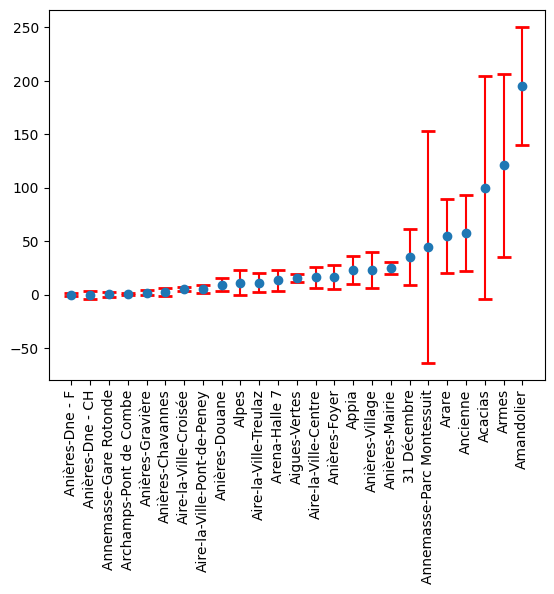

In [16]:
df_sorted = diff_mean[:25].sort_values(by='Nombre de Montées')

plt.errorbar(df_sorted[:25].index, df_sorted['Nombre de Montées'], 
             yerr=[df_sorted['Nombre de Montées'] - df_sorted['CI low'], df_sorted['CI high'] - df_sorted['Nombre de Montées']], 
             fmt='o', capsize=5, capthick=2, ecolor='red', label='Values with CI')
plt.xticks(rotation=90)